# Chapter 8

## Recipes

- Decomposing time series data
- Detecting time series stationarity
- Applying power transformations
- Testing for autocorrelation

## Bonus
- Plotting time series data using pandas
- Plotting time series data with interactive visualiztion using HvPlot

## Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import load_ch8_datasets, plot_comparison

airp_df, closing_price, co2_df = load_ch8_datasets()

In [2]:
plt.rcParams["figure.figsize"] = [12, 5]   

# Recipe 1. Decomposing Time Series

In [3]:
import statsmodels
statsmodels.__version__

'0.14.5'

In [4]:
!python --version

Python 3.13.5


In [5]:
import pandas as pd
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import matplotlib.pyplot as plt

In [6]:
plt.style.use('grayscale')

### Plot the datasets

In [7]:
co2_df.shape

(2284, 1)

In [8]:
co2_df.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

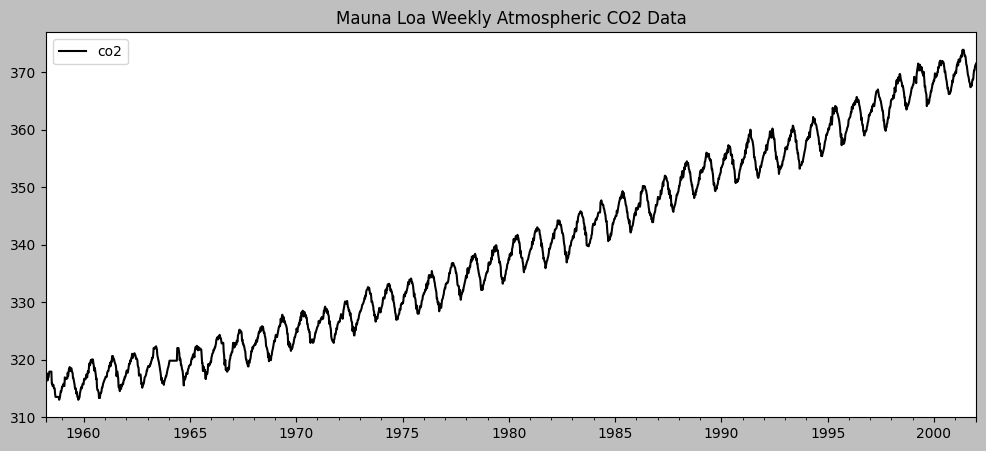

In [9]:
co2_df.plot(title='Mauna Loa Weekly Atmospheric CO2 Data');

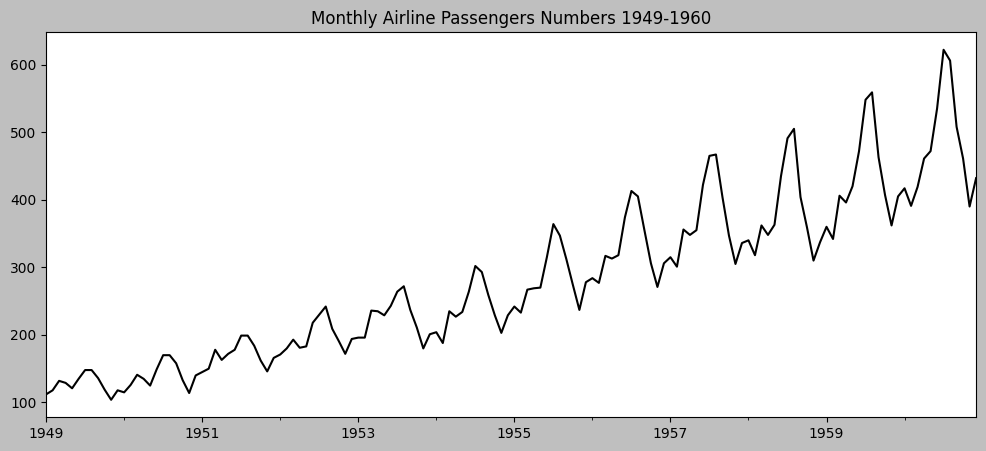

In [10]:
airp_df['passengers'].plot(title='Monthly Airline Passengers Numbers 1949-1960');

### Seasonal Decompose

In [11]:

co2_decomposed = seasonal_decompose(co2_df,model='additive')
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')

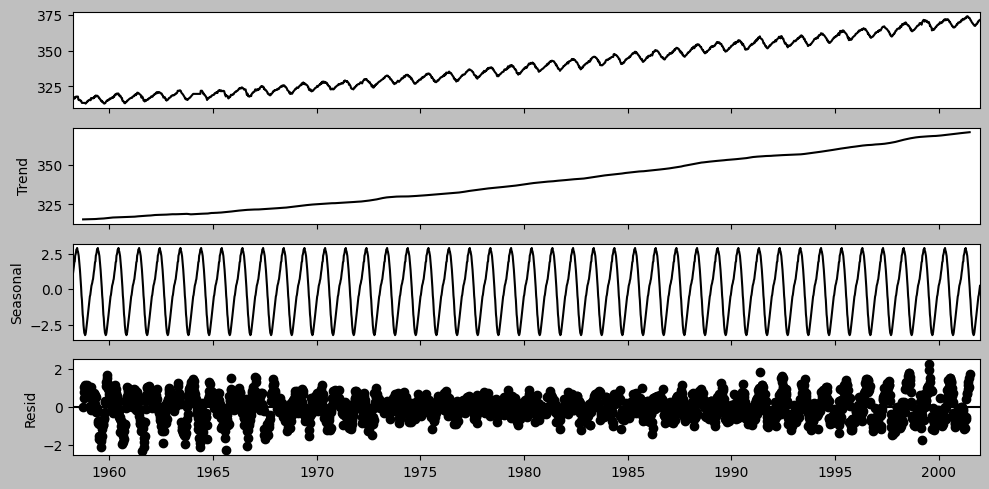

In [47]:
co2_decomposed.plot();


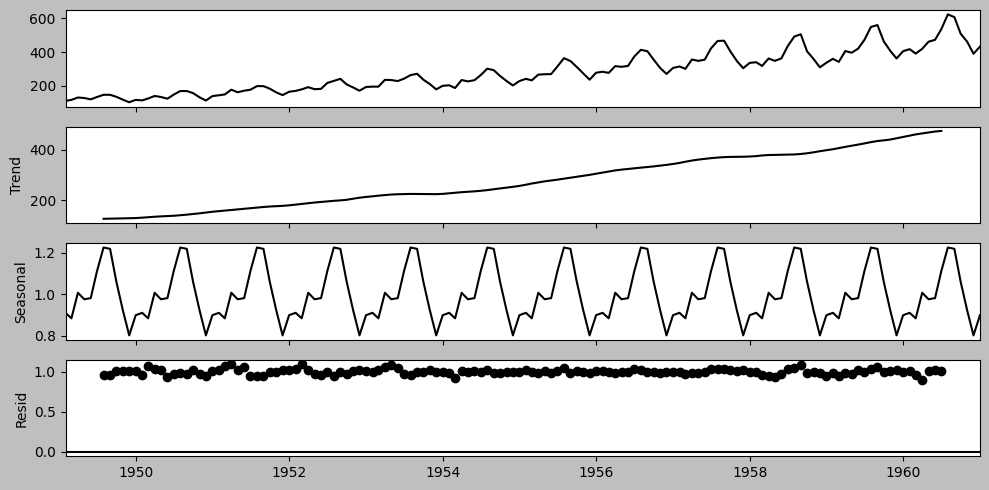

In [48]:
air_decomposed.plot();

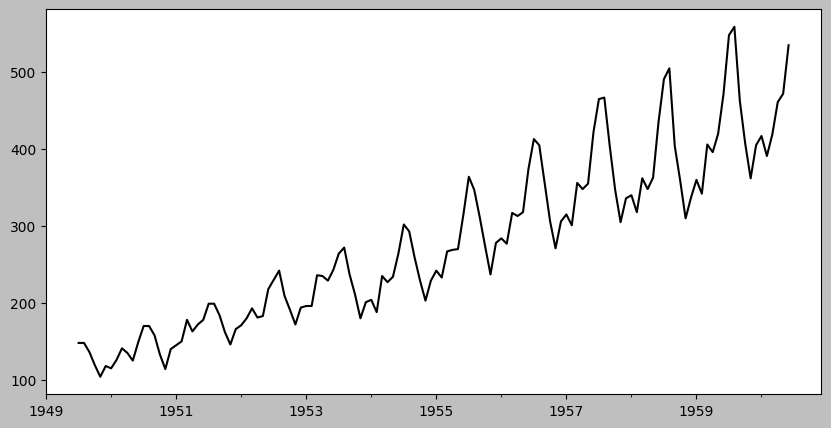

In [49]:
(air_decomposed.trend * 
 air_decomposed.seasonal * 
 air_decomposed.resid).plot();

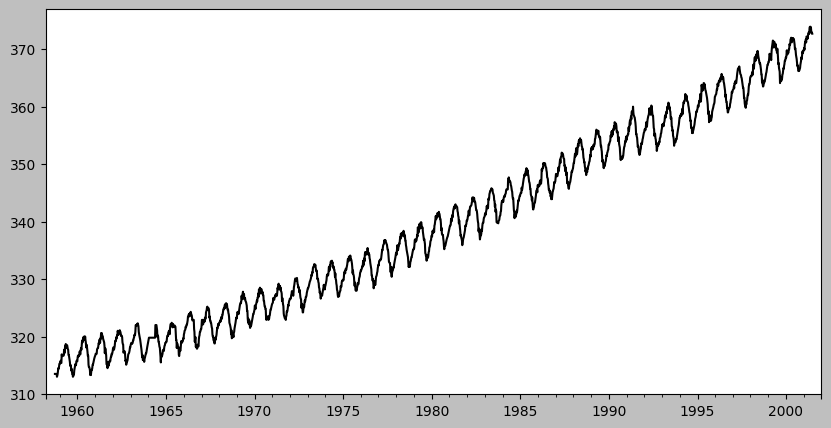

In [50]:
(co2_decomposed.trend +
 co2_decomposed.seasonal + 
 co2_decomposed.resid).plot();


### Using STL

In [51]:
print(co2_df.index.freq)

<Week: weekday=5>


In [52]:
print(airp_df.index.freq)

<MonthEnd>


In [53]:
co2_stl = STL(
    co2_df, 
    seasonal=53, 
    period=52,
    robust=True).fit()

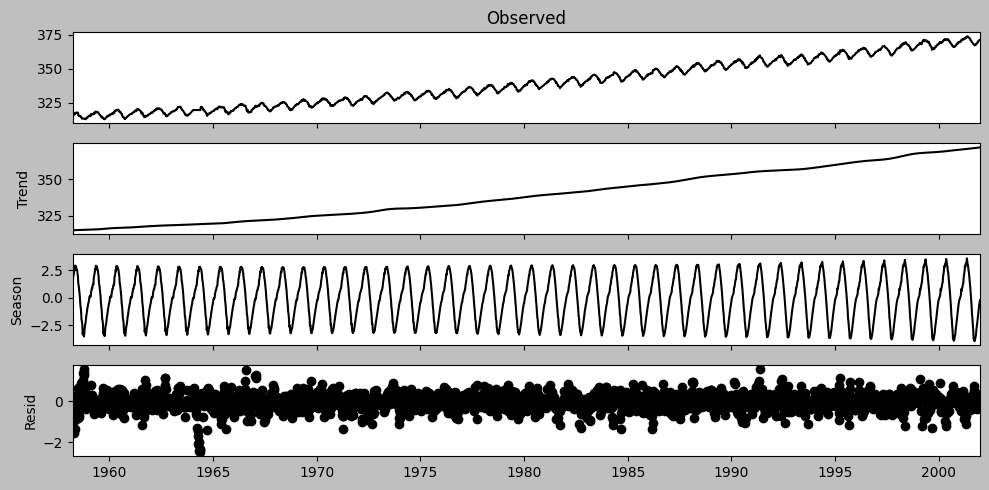

In [54]:
co2_stl.plot();

<Axes: >

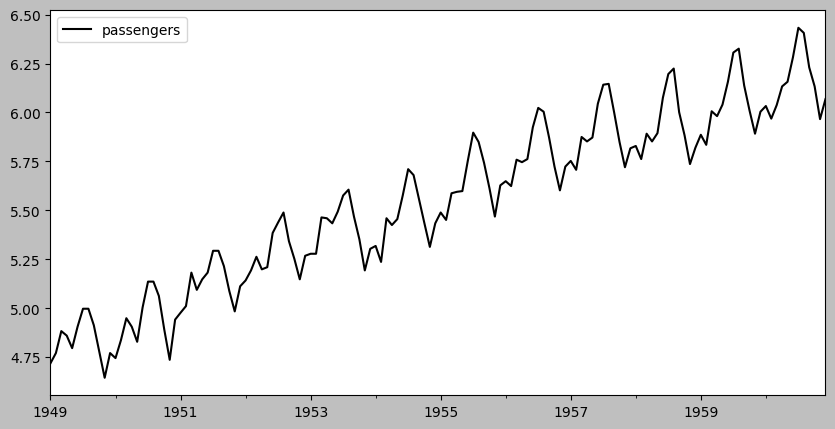

In [55]:
import numpy as np
np.log(airp_df).plot()

In [56]:
import numpy as np
airp_stl = STL(
    np.log(airp_df), 
    period=12,
    seasonal=13, 
    robust=True).fit()

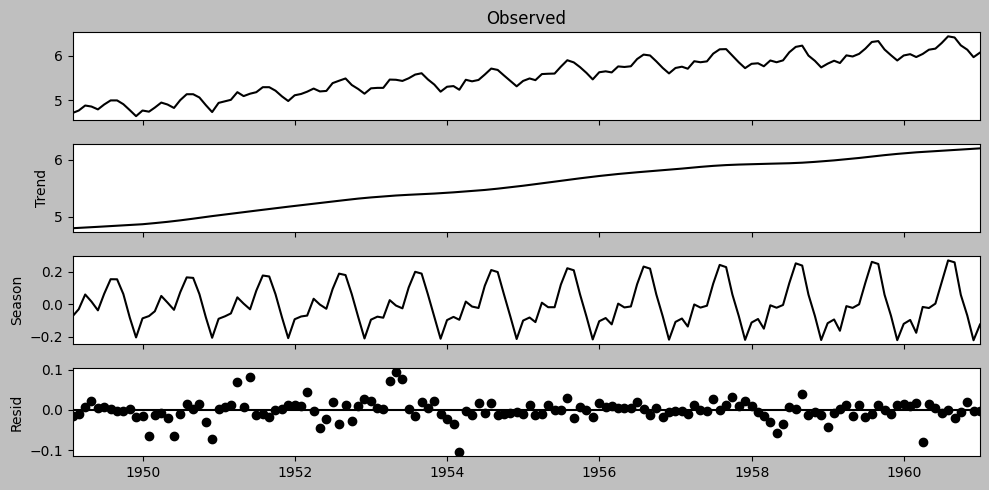

In [57]:
airp_stl.plot();

In [58]:
co2_stl

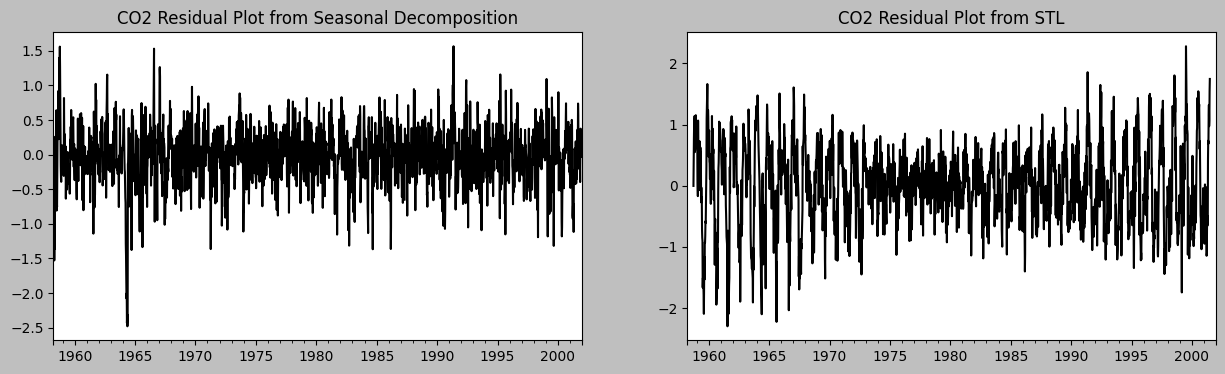

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
co2_stl.resid.plot(ax=ax1, title='CO2 Residual Plot from Seasonal Decomposition')
co2_decomposed.resid.plot(ax=ax2, title='CO2 Residual Plot from STL');

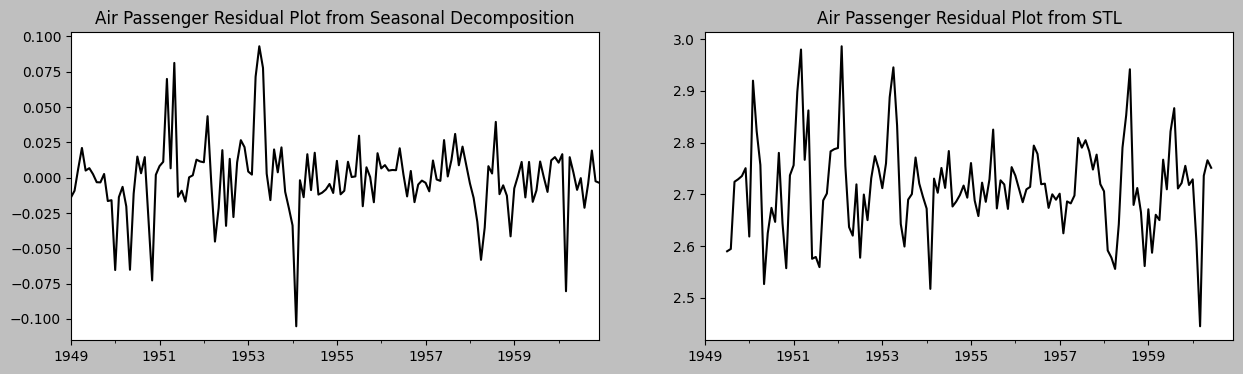

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
airp_stl.resid.plot(ax=ax1, title='Air Passenger Residual Plot from Seasonal Decomposition')
np.exp(air_decomposed.resid).plot(ax=ax2, title='Air Passenger Residual Plot from STL');

## There is more

In [61]:
# plt.rcParams["figure.figsize"] = (20,3)
from statsmodels.tsa.filters.hp_filter import hpfilter

In [62]:
co2_cyclic, co2_trend = hpfilter(co2_df)

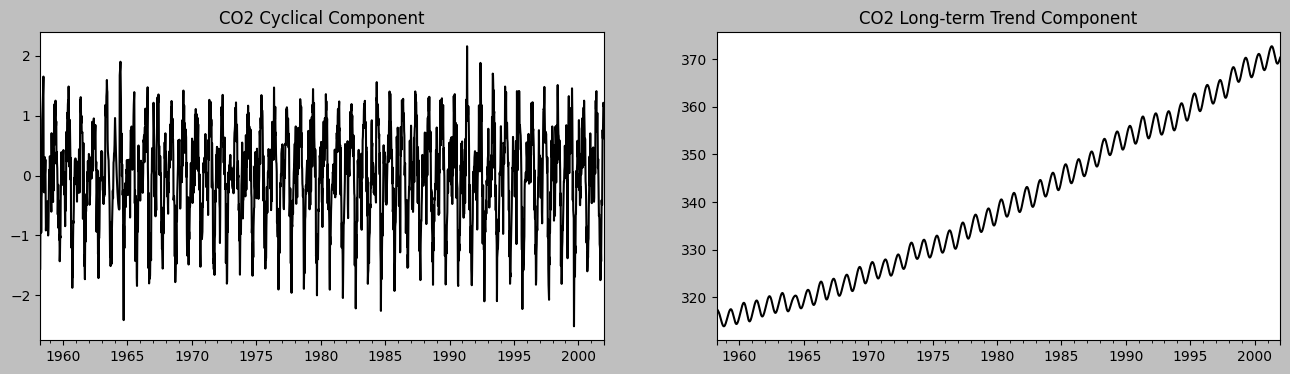

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 Cyclical Component')
co2_trend.plot(ax=ax[1], title='CO2 Long-term Trend Component');



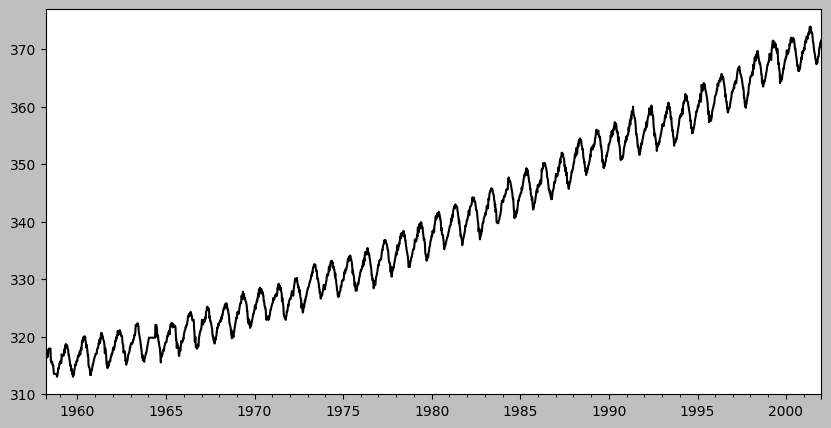

In [64]:
(co2_cyclic + co2_trend).plot();

In [65]:
airp_cyclic, airp_trend = hpfilter(airp_df)

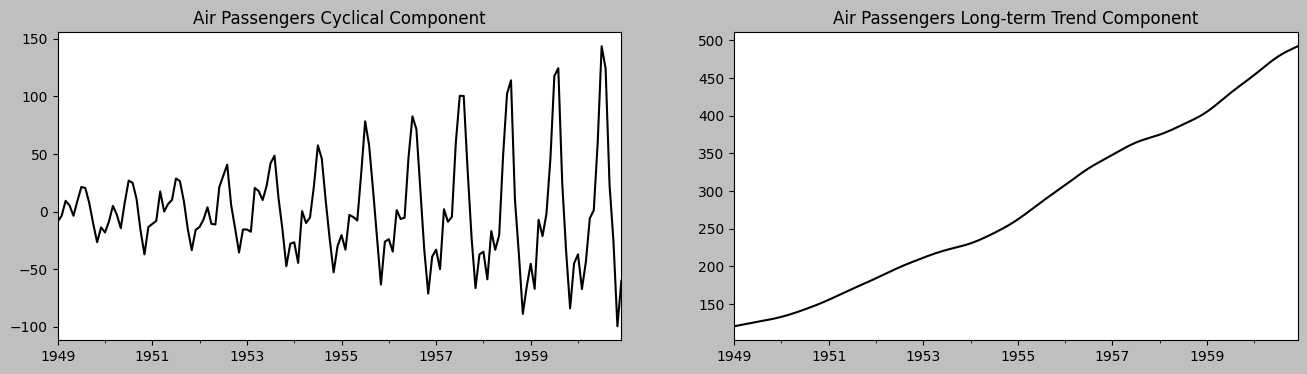

In [66]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
airp_cyclic.plot(ax=ax[0], title='Air Passengers Cyclical Component')
airp_trend.plot(ax=ax[1], title='Air Passengers Long-term Trend Component');


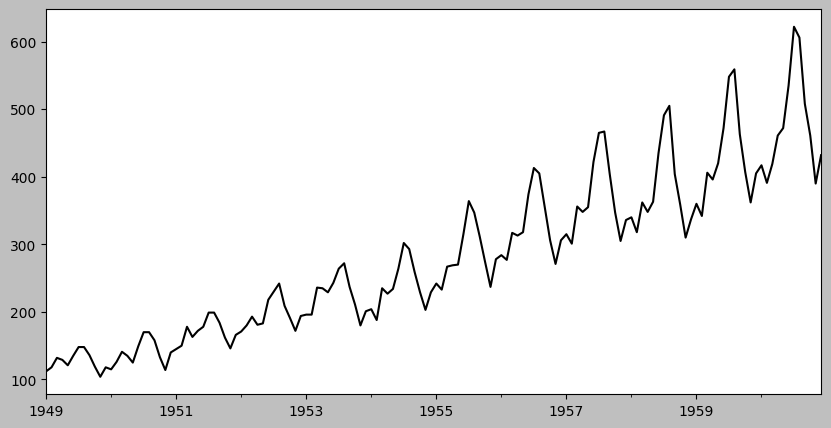

In [67]:
(airp_cyclic + airp_trend).plot();

In [68]:
((airp_cyclic + airp_trend) == airp_df['passengers']).sum()

np.int64(144)

In [69]:
airp_df.shape

(144, 1)

# Recipe 2. Detecting Time Series Stationarity 

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings('ignore')

In [71]:
plt.style.use('grayscale')

**Code for generating Figure 9.25**

<Axes: title={'center': 'Non-stationary Series'}>

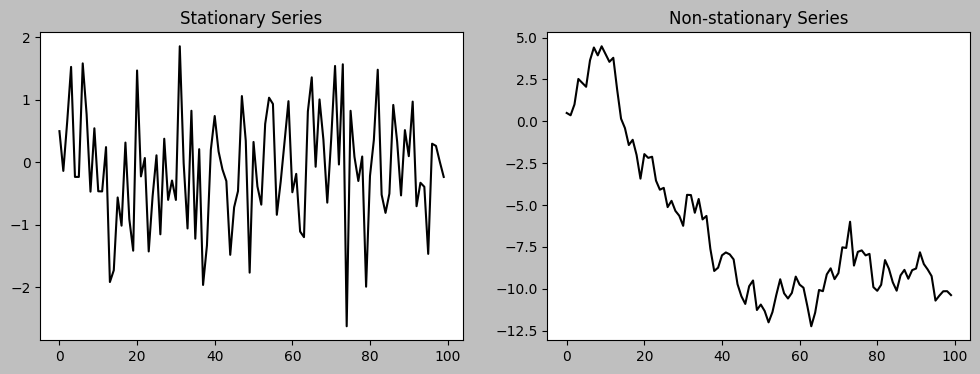

In [72]:
# Example of stationary vs non-stationary series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Stationary series
np.random.seed(42)
stationary = pd.Series(np.random.normal(0, 1, 100))
stationary.plot(ax=ax1, title='Stationary Series')
# Non-stationary series (random walk)
non_stationary = stationary.cumsum()
non_stationary.plot(ax=ax2, title='Non-stationary Series')

In [73]:
plt.style.use('grayscale')

<Axes: >

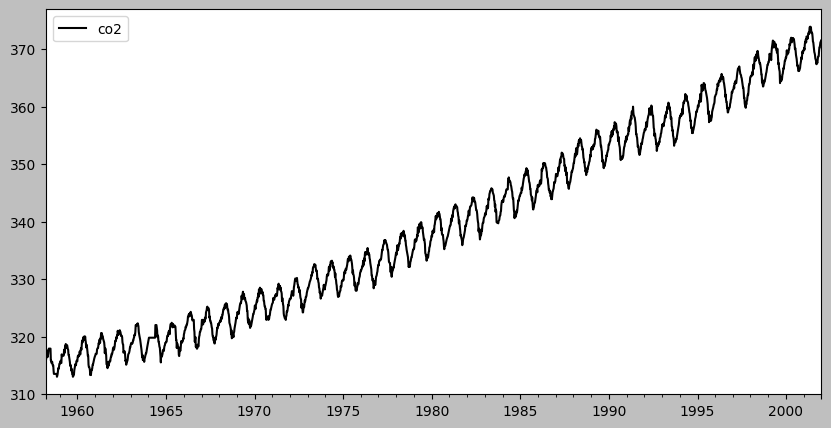

In [74]:
co2_df.plot()

In [75]:
# co2_df.plot(kind='hist')

In [76]:
co2_df.shape

(2284, 1)

In [77]:
# n = co2_df.shape[0]
# lags = int(12*(n/100)**(0.25))

In [78]:
def format_test_results(output, critical_values, decision, test):
    """Format the test results into a pandas Series."""
    output_dict = {
        'Test Statistic': output[0],
        'p-value': output[1],
        'Number of lags': output[2],
        'Decision': decision
    }
    for key, value in critical_values.items():
        output_dict[f"Critical Value ({key})"] = value
    return pd.Series(output_dict, name=test)

def adf_results(data):
    """Perform ADF test and format results."""
    output = adfuller(data)
    decision = "Stationary" if output[1] < 0.05 else "Non-Stationary"
    return format_test_results(output, output[4], decision, test='ADF')

def kpss_results(data):
    """Perform KPSS test and format results."""
    output = kpss(data)
    decision = "Stationary" if output[1] >= 0.05 else "Non-Stationary"
    return format_test_results(output, output[3], decision, test='KPSS')


In [79]:
adf_results(co2_df)

Test Statistic                0.046051
p-value                       0.962179
Number of lags                      27
Decision                Non-Stationary
Critical Value (1%)          -3.433252
Critical Value (5%)          -2.862822
Critical Value (10%)         -2.567452
Name: ADF, dtype: object

In [80]:
kpss_results(co2_df)

Test Statistic                 7.649196
p-value                            0.01
Number of lags                       29
Decision                 Non-Stationary
Critical Value (10%)              0.347
Critical Value (5%)               0.463
Critical Value (2.5%)             0.574
Critical Value (1%)               0.739
Name: KPSS, dtype: object

In [81]:
adf_output = adf_results(co2_df)
kpss_output = kpss_results(co2_df)

In [82]:
print(pd.concat([adf_output, kpss_output], axis=1))

                                  ADF            KPSS
Test Statistic               0.046051        7.649196
p-value                      0.962179            0.01
Number of lags                     27              29
Decision               Non-Stationary  Non-Stationary
Critical Value (1%)         -3.433252           0.739
Critical Value (5%)         -2.862822           0.463
Critical Value (10%)        -2.567452           0.347
Critical Value (2.5%)             NaN           0.574


In [83]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.filters.hp_filter import hpfilter

# using first order differencing (detrending)
first_ord_diff = co2_df.diff().dropna()

# using second order differencing
second_ord_diff = co2_df.diff().diff().dropna()

# differencing to remove seasonality
deseasonalize = co2_df.diff(52).dropna()

# using rolling mean 
rolling_mean = co2_df.rolling(window=52).mean()
rolling_mean = co2_df - rolling_mean

# log transform
log_transform = np.log(co2_df)

# using seasonal_decompose to remove trend
decomp = seasonal_decompose(co2_df)
seasonal_decomp = decomp.resid

# using STL
co2_stl = STL(co2_df, seasonal=13,robust=True).fit()
stl_decomp = co2_stl.resid

# using hp_filter 
hp_cyclic, hp_trend = hpfilter(co2_df)

# combine the methods into a list
methods = [first_ord_diff, second_ord_diff, 
           deseasonalize, rolling_mean, 
           log_transform,  seasonal_decomp, 
           stl_decomp, hp_cyclic]

In [85]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=10)               ## 
# plt.rc('axes', labelsize=12)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=10)             ## 
#############################################

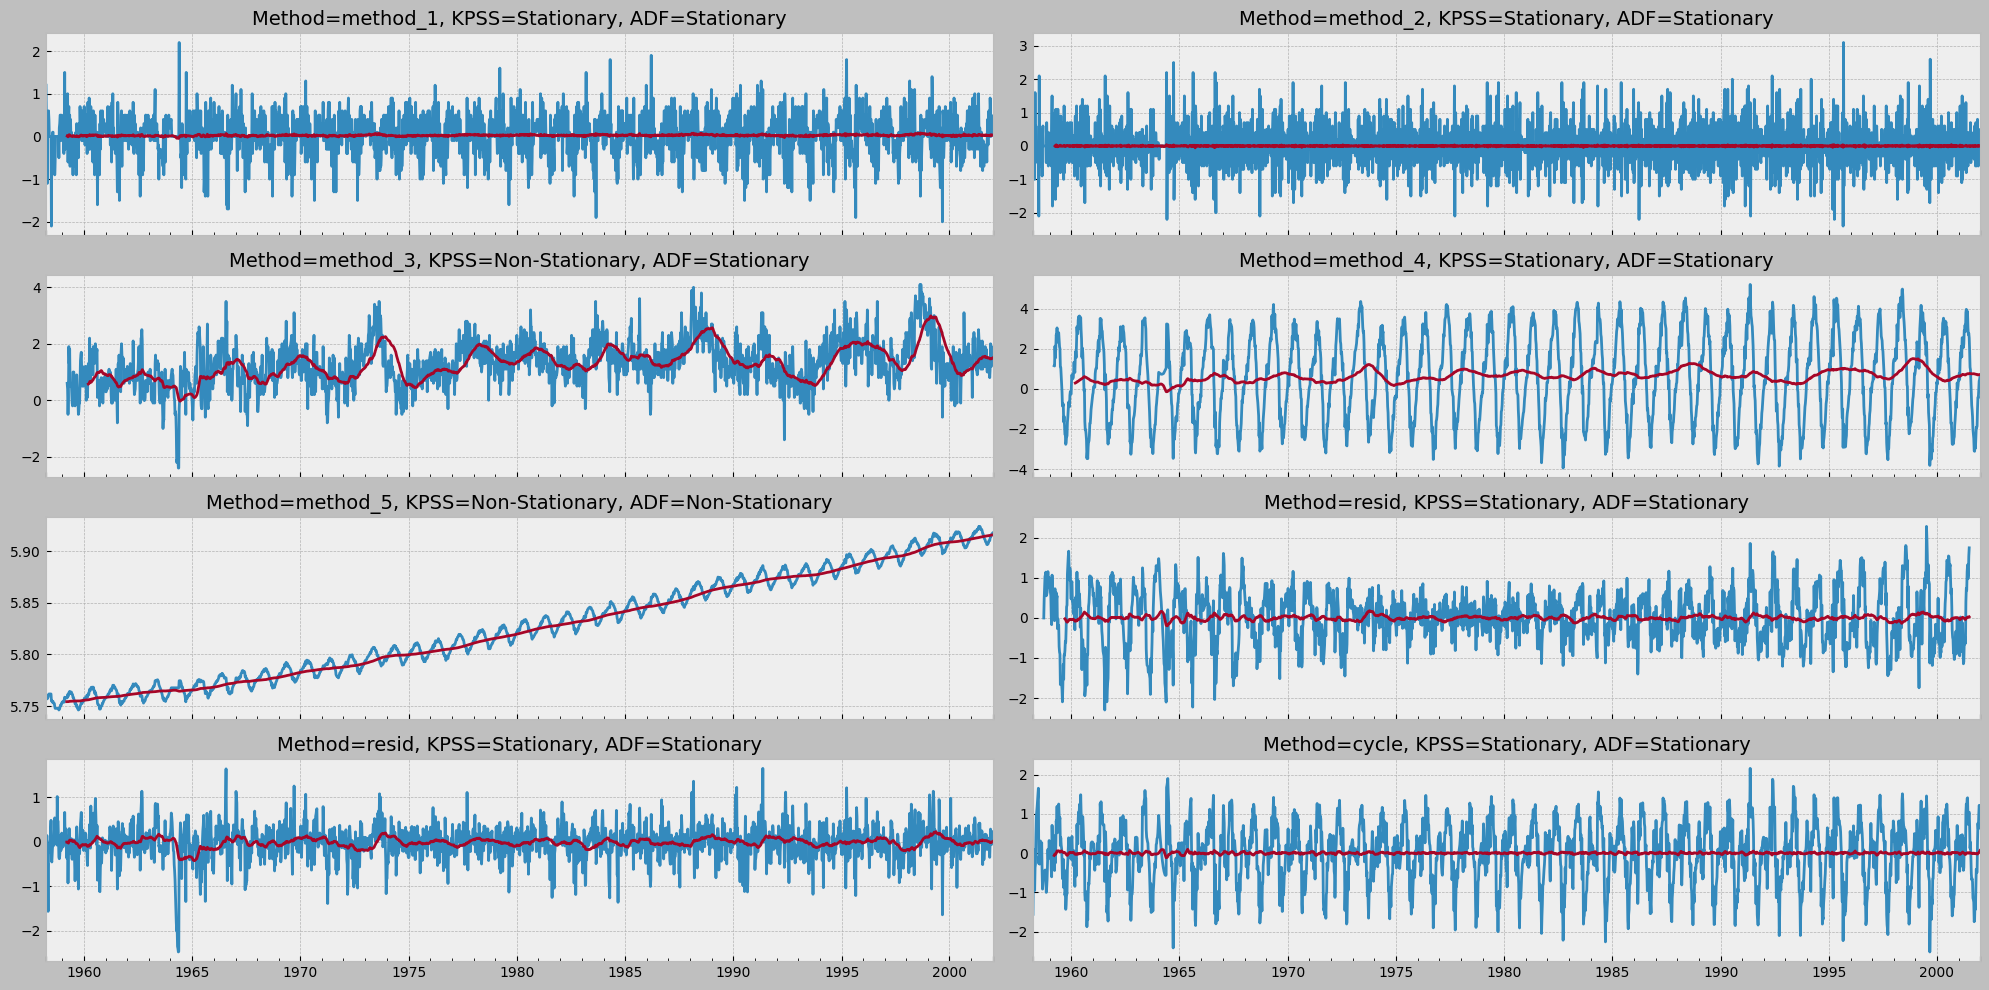

In [ ]:
plt.style.use('bmh')
plot = plot_comparison(methods, kpss_results, adf_results, plot_type='line')
warnings.simplefilter(action='ignore')


### There is more

In [87]:
adf_result = adfuller(first_ord_diff, regresults=True)
# kpss_result = kpss(first_ord_diff, store=True, regression='c')

In [88]:
adf_result[3]

In [89]:
adf_result[-1].resols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     112.4
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        12:51:16   Log-Likelihood:                -1300.1
No. Observations:                2255   AIC:                             2658.
Df Residuals:                    2226   BIC:                             2824.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.2089      0.078    -15.517      0.000      -1.362      -1.056
x2             0.0694      0.074      0.934      0.351      -0.076       0.215
x3             0.0549      0.071      0.771      0.441      -0.085       0.194
x4             0.2661      0.068      3.894      0.000       0.132       0.400
x5             0.4363      0.066      6.603      0.000       0.307       0.566
x6             0.6273      0.064      9.780      0.000       0.502       0.753
x7             0.7159      0.063     11.377      0.000       0.592       0.839
x8             0.8211      0.062     13.246      0.000       0.699       0.943
x9             0.8455      0.061     13.779      0.000       0.725       0.966
x10            0.8269      0.061     13.641      0.000       0.708       0.946
x11            0.7763      0.060     13.011      0.000       0.659       0.893
x12            0.6904      0.058     11.815      0.000       0.576       0.805
x13            0.5949      0.057     10.486      0.000       0.484       0.706
x14            0.4798      0.055      8.736      0.000       0.372       0.588
x15            0.3971      0.053      7.466      0.000       0.293       0.501
x16            0.3136      0.052      6.074      0.000       0.212       0.415
x17            0.2572      0.050      5.096      0.000       0.158       0.356
x18            0.2521      0.050      5.082      0.000       0.155       0.349
x19            0.2443      0.049      4.982      0.000       0.148       0.341
x20            0.2534      0.049      5.211      0.000       0.158       0.349
x21            0.2867      0.048      5.940      0.000       0.192       0.381
x22            0.3286      0.048      6.864      0.000       0.235       0.422
x23            0.3501      0.047      7.426      0.000       0.258       0.443
x24            0.3452      0.046      7.504      0.000       0.255       0.435
x25            0.3440      0.044      7.904      0.000       0.259       0.429
x26            0.2724      0.039      6.924      0.000       0.195       0.350
x27            0.1844      0.032      5.846      0.000       0.123       0.246
x28            0.0940      0.021      4.493      0.000       0.053       0.135
const          0.0299      0.009      3.201      0.001       0.012       0.048
==============================================================================
Omnibus:                       57.058   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.961
Skew:                           0.023   Prob(JB):                     2.21e-29
Kurtosis:                       4.184   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is co

# Recipe 3. Applying Power Transformations to Time Series Data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, boxcox
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_goldfeldquandt, 
                                   het_white, jarque_bera,
                                   omni_normtest, normal_ad)
from statsmodels.stats.diagnostic import kstest_normal, normal_ad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import ols
from statsmodels.tools.tools import add_constant

**Code for Figure 29**

In [13]:
plt.rcParams["figure.figsize"] = (14,6)
plt.style.use('grayscale')

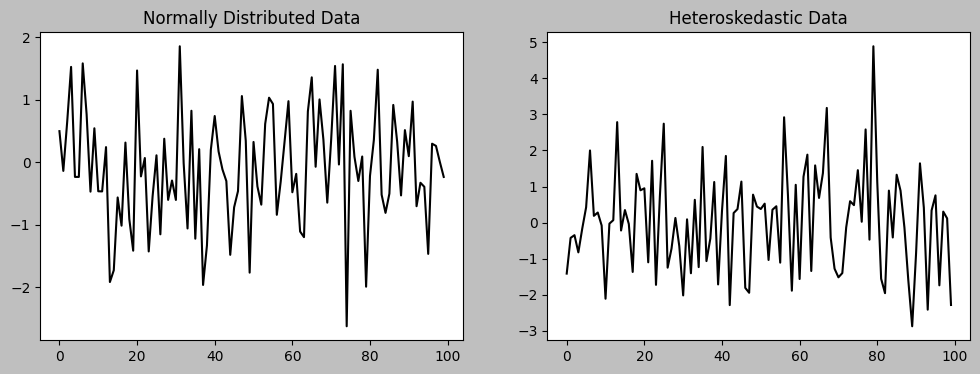

In [14]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n = 100
# Normally distributed data
normal_data = np.random.normal(0, 1, n)
# Heteroskedastic data: variance increases with time
heteroskedastic_data = np.random.normal(0, 1, n) * np.linspace(1, 2, n)

# Create a DataFrame
synthetic_data = pd.DataFrame({'Normal': normal_data, 'Heteroskedastic': heteroskedastic_data})

# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
synthetic_data['Normal'].plot(ax=ax1, title='Normally Distributed Data')
synthetic_data['Heteroskedastic'].plot(ax=ax2, title='Heteroskedastic Data')
plt.show()

### Testing for Normality

In [15]:
from scipy.stats import shapiro, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

In [16]:
def is_normal(test, p_level=0.05):
    """
    Determines if data is normally distributed based on test statistics.
    
    Parameters:
        test: Tuple of (statistic, p-value) from normality test
        p_level: Significance level (default: 0.05)
    
    Returns:
        str: 'Normal' if p-value > p_level, 'Not Normal' otherwise
    """
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

<Axes: >

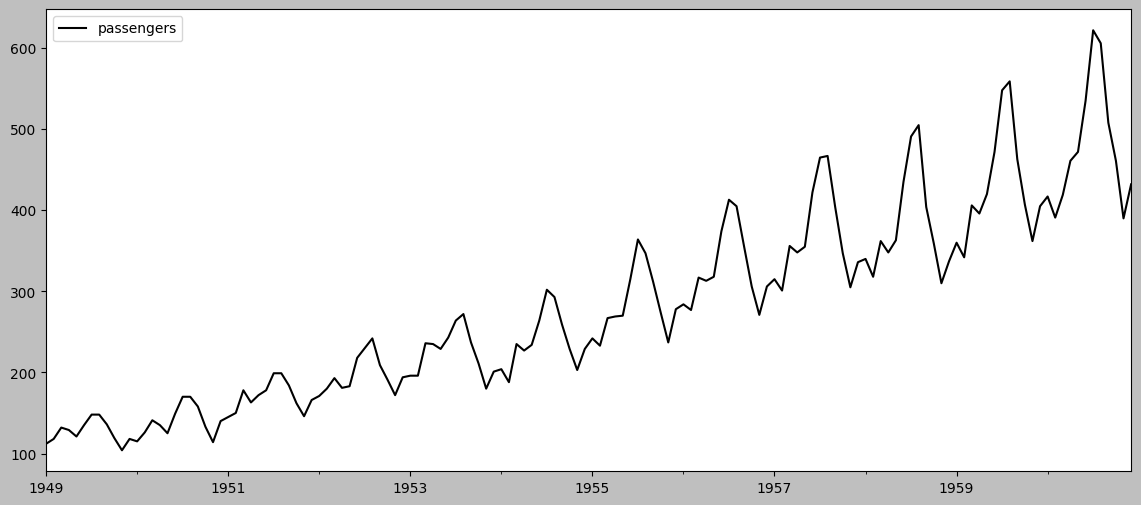

In [17]:
plt.style.use('grayscale')
#co2_df.plot()
airp_df.plot()

In [18]:
print("Shapiro-Wilk Test:", is_normal(shapiro(airp_df)))
print("D'Agostino-Pearson Test:", is_normal(normaltest(airp_df)))
print("Anderson–Darling Test:",is_normal(normal_ad(airp_df)))
print("Kolmogorov–Smirnov Test:", is_normal(kstest_normal(airp_df)))

Shapiro-Wilk Test: Not Normal
D'Agostino-Pearson Test: Not Normal
Anderson–Darling Test: Not Normal
Kolmogorov–Smirnov Test: Not Normal


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(airp_df,
                trend="c",
                order=(2,1,2),  # non-seasonal part (p,d,q)
                seasonal_order=(0,1,1,12),  # seasonal part (P,D,Q,s)
                enforce_stationarity=False
               ).fit()

/Users/tarekatwan/Repos/MyWork/Write/Time-Series-Analysis-with-Python-Cookbook-Second-Edition/code/Ch8/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -449.032
Date:                              Sat, 13 Dec 2025   AIC                            912.064
Time:                                      23:58:34   BIC                            931.339
Sample:                                  01-31-1949   HQIC                           919.888
                                       - 12-31-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0452      0.044      1.034      0.301      -0.040       0.131
ar.L1          0.3293      0.467      0.704      0.481      -0.587       1.245
ar.L2          0.3569      0.331      1.079      0.281      -0.292       1.005
ma.L1         -0.7472     11.342     -0.066      0.947     -22.977      21.482
ma.L2         -0.2526      2.841     -0.089      0.929      -5.821       5.316
ma.S.L12      -0.1196      0.123     -0.970      0.332      -0.361       0.122
sigma2       132.0828   1484.917      0.089      0.929   -2778.301    3042.467
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 7.06
Prob(Q):                              0.88   Prob(JB):                         0.03
Heteroskedasticity (H):               2.11   Skew:                             0.07
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

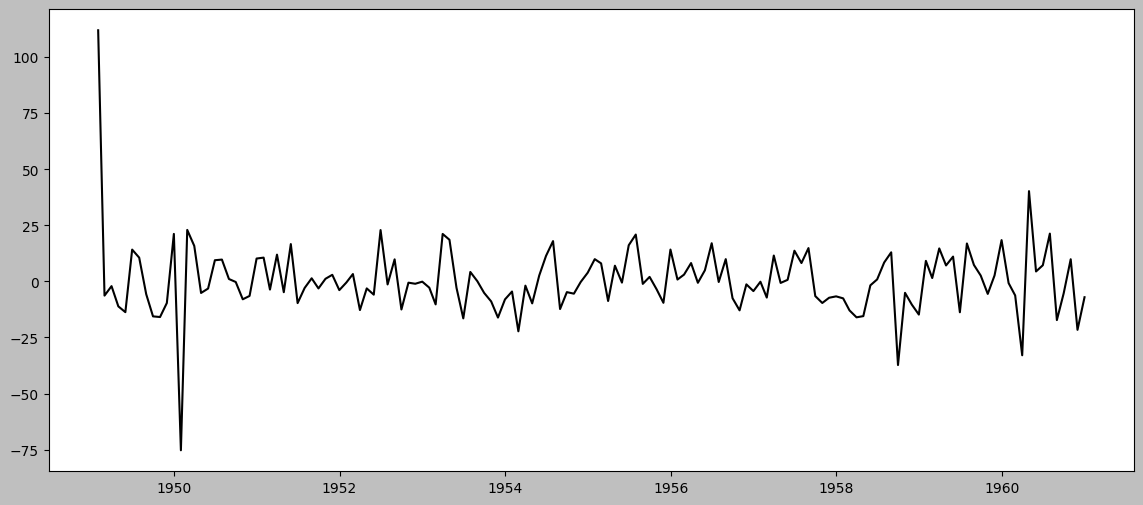

In [21]:
# plot model's raw residuals
plt.plot(model.resid)

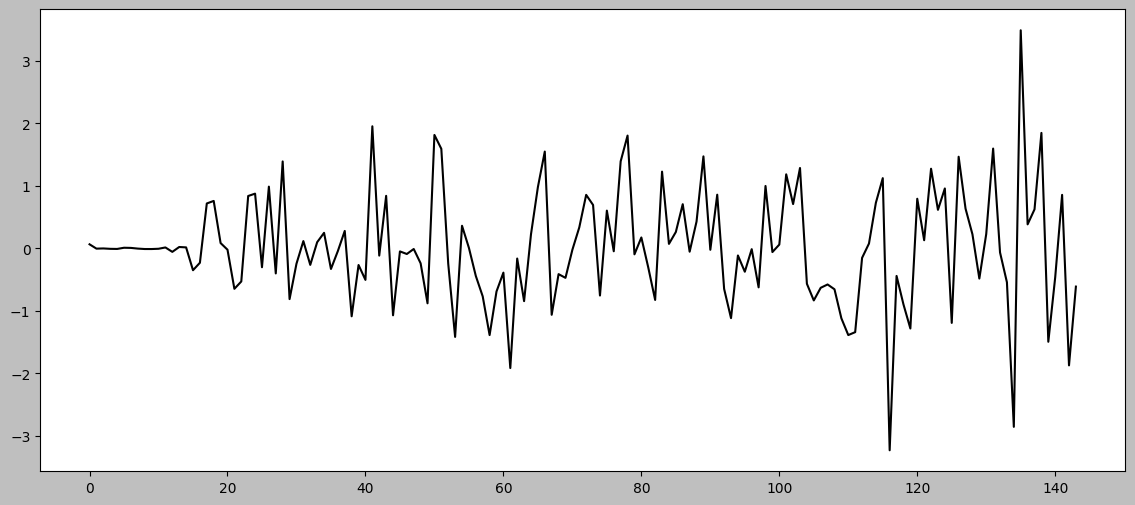

In [22]:
# plot the standardized residuals
plt.plot(model.filter_results.standardized_forecasts_error[0]);

In [23]:
standardized_residuals = (
    model.filter_results.standardized_forecasts_error[0]
)

In [24]:
print("Shapiro-Wilk Test:", 
          is_normal(shapiro(standardized_residuals)))
print("D'Agostino-Pearson Test:", 
          is_normal(normaltest(standardized_residuals)))
print("Anderson–Darling Test:",
          is_normal(normal_ad(standardized_residuals)))
print("Kolmogorov–Smirnov Test:", 
          is_normal(kstest_normal(standardized_residuals)))


Shapiro-Wilk Test: Not Normal
D'Agostino-Pearson Test: Not Normal
Anderson–Darling Test: Not Normal
Kolmogorov–Smirnov Test: Not Normal


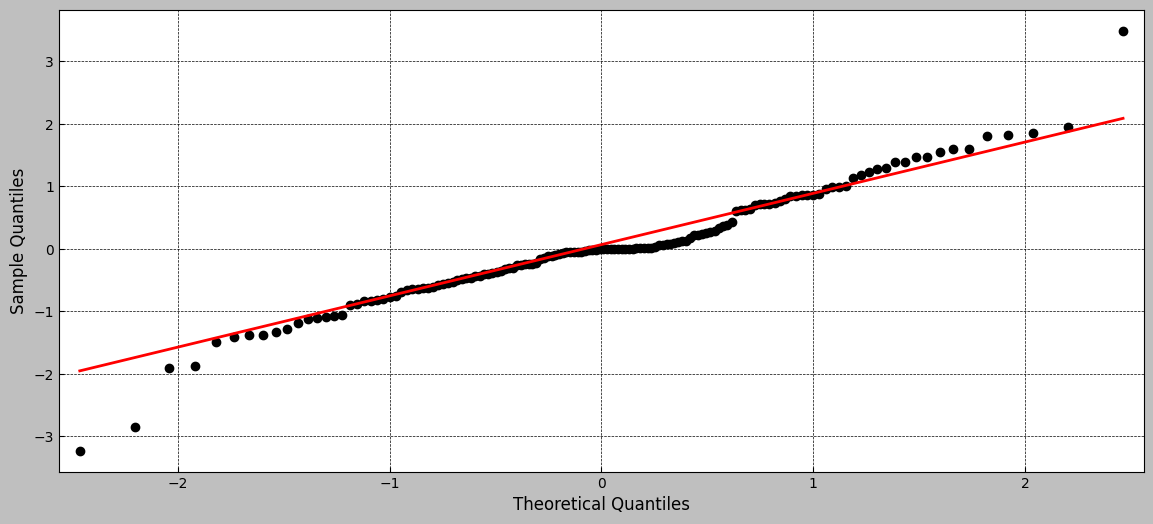

In [103]:
from statsmodels.graphics.gofplots import qqplot
qqplot(standardized_residuals, line='q');

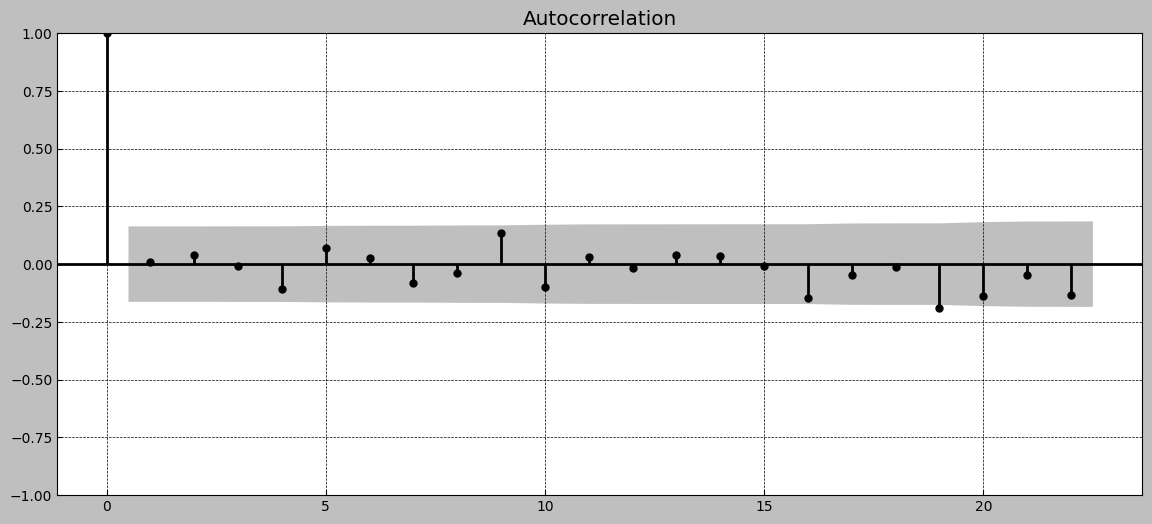

In [104]:
plot_acf(standardized_residuals);

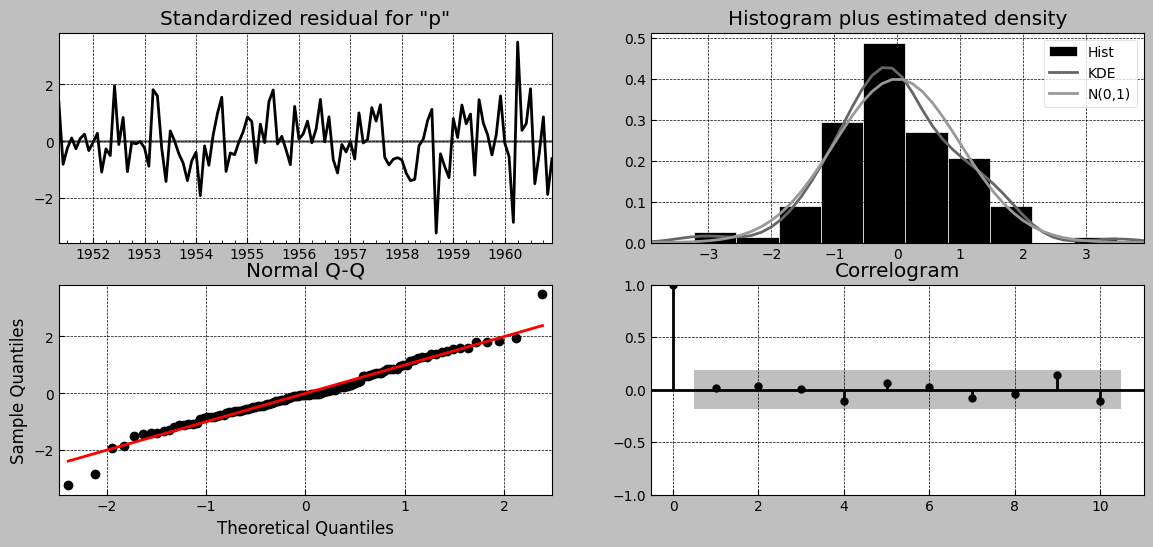

In [105]:
model.plot_diagnostics();

In [106]:
model.test_normality(None)

array([[7.06242925, 0.02926934, 0.06714465, 4.20131538]])

In [107]:
model.test_heteroskedasticity(None)

array([[2.11230491, 0.0217914 ]])

### Testing Homoskedactiticy

In [108]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)

In [109]:
def het_test(model, test=het_breuschpagan, p_level=0.05):
    """
    Determines if residuals exhibit heteroskedasticity based on test statistics.
    
    Parameters:
        model: Fitted model object containing residuals and fitted values
        test: Statistical test function (default: het_breuschpagan)
        p_level: Significance level (default: 0.05)
    
    Returns:
        str: 'Homoskedastic' if p-value > p_level, 'Heteroskedastic' otherwise
    """
    lm, lm_pvalue, fvalue, f_pvalue = test(
        model.filter_results.standardized_forecasts_error[0],
        add_constant(model.fittedvalues)
    )
    
    return "Heteroskedastic" if f_pvalue < p_level else "Homoskedastic"


In [110]:
print("Breusch-Pagan Test:", het_test(model, test=het_breuschpagan))
print("White Test:", het_test(model, test=het_white))

Breusch-Pagan Test: Heteroskedastic
White Test: Heteroskedastic


### Box-Cox Transformation

In [111]:
from scipy.stats import boxcox

In [112]:
airp_df

passengers
1949-01-31         112
1949-02-28         118
1949-03-31         132
1949-04-30         129
1949-05-31         121
...                ...
1960-08-31         606
1960-09-30         508
1960-10-31         461
1960-11-30         390
1960-12-31         432

[144 rows x 1 columns]

In [113]:
# Box-Cox transformation requires positive values
if (airp_df['passengers'] <= 0).any():
    raise ValueError("Box-Cox transformation requires all positive values")
xt, lmbda = boxcox(airp_df['passengers'])

In [114]:
print(lmbda)

0.1480226858137178


In [115]:
print(is_normal(shapiro(xt)))

Not Normal


In [116]:
print(lmbda)

0.1480226858137178


In [117]:
xts = pd.Series(xt, index=airp_df.index)

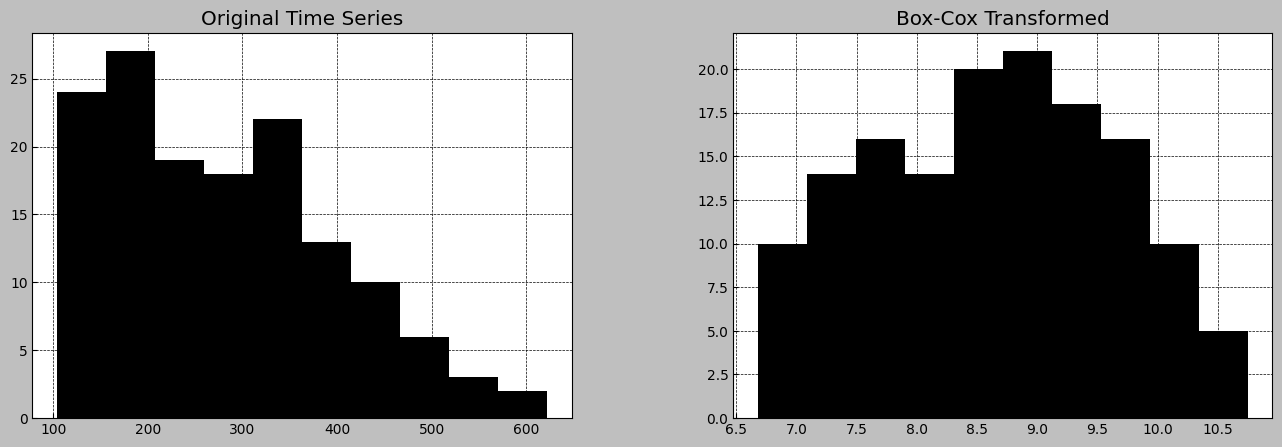

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed');


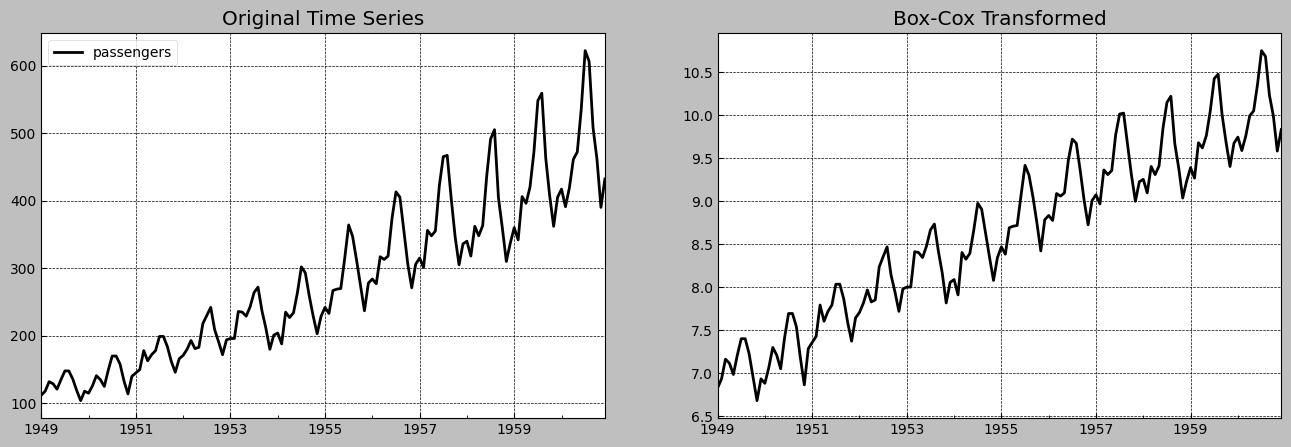

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
airp_df.plot(ax=ax[0])
ax[0].set_title('Original Time Series')
ax[0].grid(True)
xts.plot(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')
ax[1].grid(True);

In [120]:
# model_air = AutoReg(co2_df, lags=1, trend='n').fit()
# model_bx = AutoReg(xts, lags=1, trend='n').fit()

model_bx = SARIMAX(xts,
                trend="c",
                order=(2,1,2),  # non-seasonal part (p,d,q)
                seasonal_order=(0,1,1,12),  # seasonal part (P,D,Q,s)
                enforce_stationarity=False
               ).fit()

In [121]:
model_bx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 124.125
Date:                              Thu, 04 Dec 2025   AIC                           -234.250
Time:                                      12:51:21   BIC                           -214.975
Sample:                                  01-31-1949   HQIC                          -226.425
                                       - 12-31-1960                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.000     -1.151      0.250      -0.001       0.000
ar.L1         -0.0262      0.341     -0.077      0.939      -0.694       0.641
ar.L2          0.5341      0.195      2.734      0.006       0.151       0.917
ma.L1         -0.3499      0.372     -0.942      0.346      -1.078       0.378
ma.L2         -0.5689      0.332     -1.715      0.086      -1.219       0.081
ma.S.L12      -0.5452      0.116     -4.714      0.000      -0.772      -0.318
sigma2         0.0068      0.001      8.297      0.000       0.005       0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 6.29
Prob(Q):                              0.64   Prob(JB):                         0.04
Heteroskedasticity (H):               0.73   Skew:                            -0.17
Prob(H) (two-sided):                  0.33   Kurtosis:                         4.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
print("White Test:", het_test(model_bx, 
                              test=het_white)) 
print("Breusch-Pagan Test:", het_test(model_bx, 
                                      test=het_breuschpagan)) 

White Test: Homoskedastic
Breusch-Pagan Test: Homoskedastic


In [123]:
s_resid = model_bx.filter_results.standardized_forecasts_error[0]

print("Shapiro-Wilk Test:", is_normal(shapiro(s_resid)))
print("D'Agostino-Pearson Test:", is_normal(normaltest(s_resid)))
print("Anderson–Darling Test:",is_normal(normal_ad(s_resid)))
print("Kolmogorov–Smirnov Test:", is_normal(kstest_normal(s_resid)))

Shapiro-Wilk Test: Not Normal
D'Agostino-Pearson Test: Not Normal
Anderson–Darling Test: Not Normal
Kolmogorov–Smirnov Test: Normal


In [124]:
'Normal' if jarque_bera(s_resid)[1] > 0.05 else 'Not Normal'

'Not Normal'

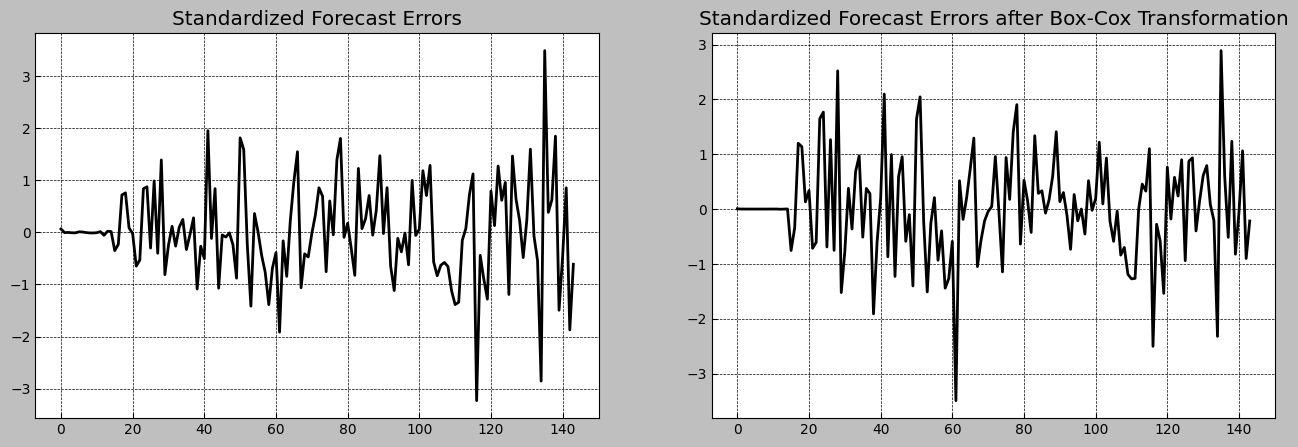

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].plot(model.filter_results.standardized_forecasts_error[0])
ax[1].plot(model_bx.filter_results.standardized_forecasts_error[0])

ax[0].set_title("Standardized Forecast Errors")
ax[1].set_title("Standardized Forecast Errors after Box-Cox Transformation");


Text(0.5, 1.0, 'Standardized Forecast Errors after Box-Cox Transformation')

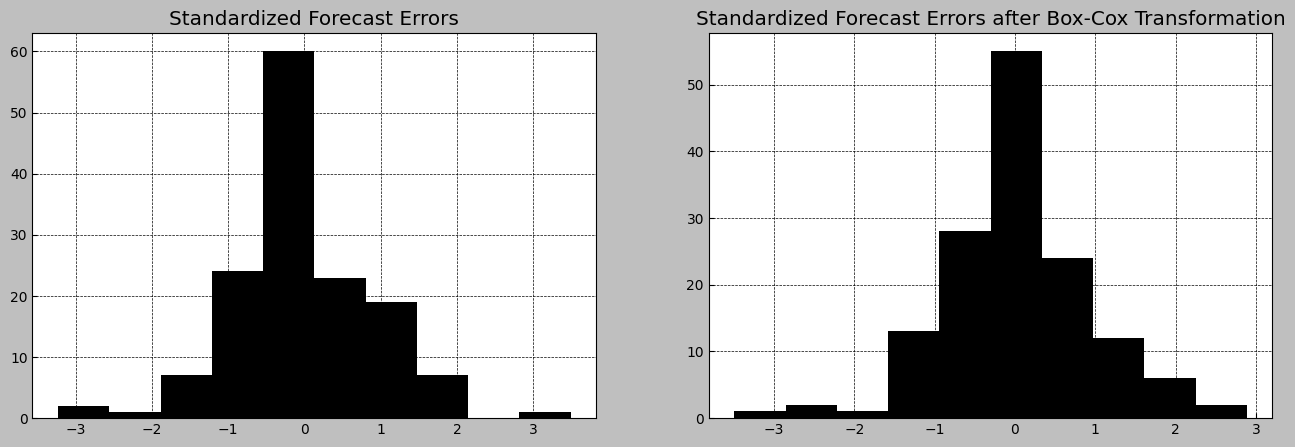

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
ax[0].hist(model.filter_results.standardized_forecasts_error[0])
ax[1].hist(model_bx.filter_results.standardized_forecasts_error[0])

ax[0].set_title("Standardized Forecast Errors")
ax[1].set_title("Standardized Forecast Errors after Box-Cox Transformation")

In [127]:
jb_test = model_bx.test_normality(method='jarquebera')
print("Jarque-Bera Test:", 
      "Normal" if jb_test[0][1] > 0.05 else "Not Normal" )

Jarque-Bera Test: Not Normal


In [128]:
gq_test = model_bx.test_heteroskedasticity(method='breakvar')
print("Goldfeld–Quandt Test:", 
      "Homoskedastic" if gq_test[0][1] > 0.05 else "Heteroskedastic" )

Goldfeld–Quandt Test: Homoskedastic


### There is more

In [129]:
from scipy.stats import boxcox, boxcox_normmax, yeojohnson, yeojohnson_normmax, yeojohnson_normplot, boxcox_normplot
from scipy.special import inv_boxcox

#### Exploring boxcox_normmax and boxcox_normplot

In [130]:
xt, lmbda = boxcox(airp_df['passengers'])
print(f"Optimal lambda from boxcox: {lmbda:.5f}")

Optimal lambda from boxcox: 0.14802


In [131]:
lmbdas = boxcox_normmax(airp_df['passengers'], method='all')

In [132]:
print(f'Using Person Correlation (personr): {lmbdas[0]:.5f}')
print(f'Using Maximum-Likelihood (mle): {lmbdas[1]:.5f}')

Using Person Correlation (personr): 0.21083
Using Maximum-Likelihood (mle): 0.14802


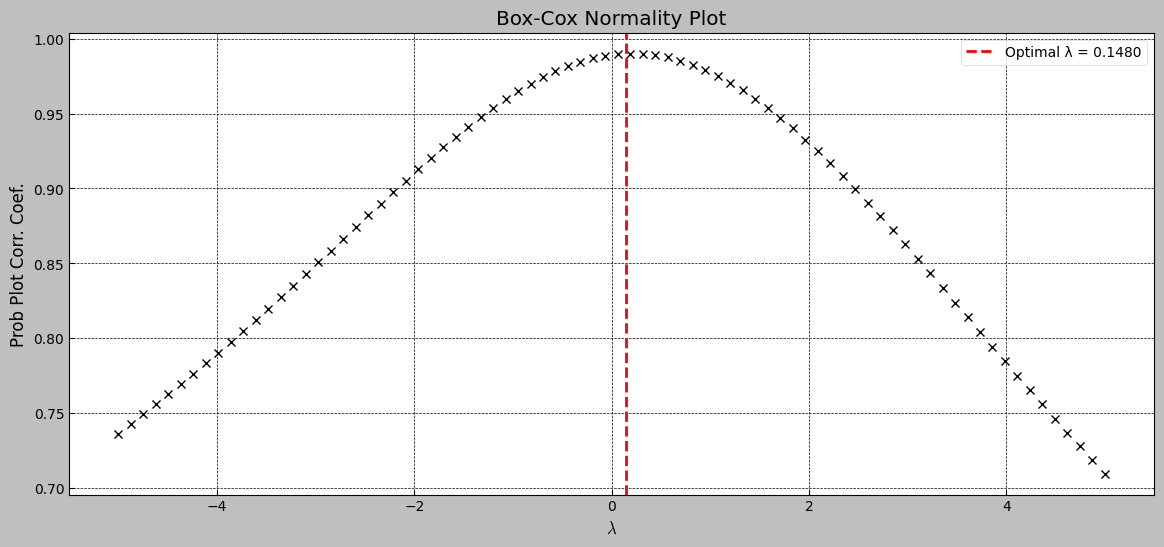

In [133]:
fig, ax = plt.subplots()
boxcox_normplot(airp_df['passengers'], la=-5, lb=5, plot=ax);
_, optimal_lambda = boxcox(airp_df['passengers']) 
ax.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal λ = {optimal_lambda:.4f}')
plt.legend()
plt.show()

In [134]:
lmbda

np.float64(0.1480226858137178)

<Axes: >

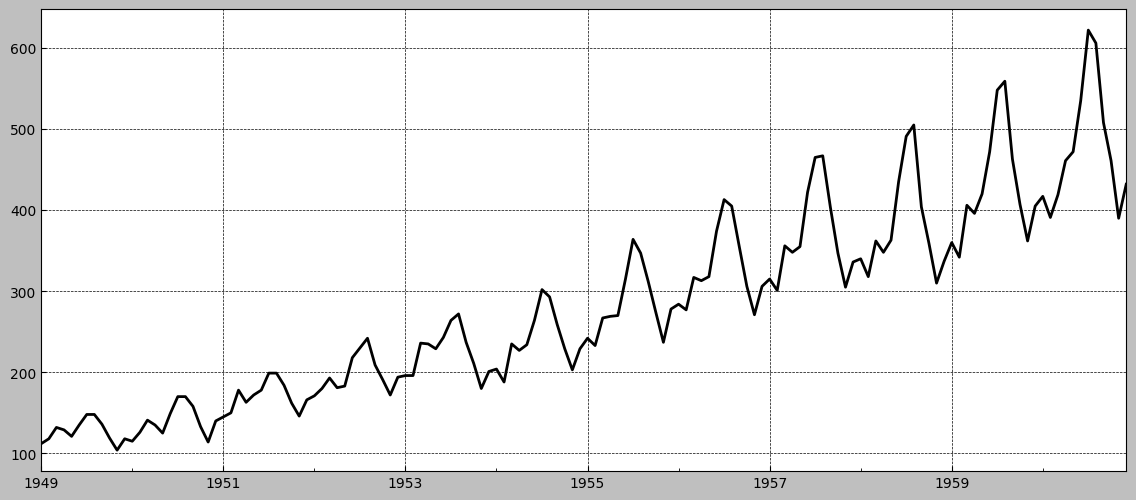

In [135]:
airp_restored = pd.Series(inv_boxcox(xt, lmbda), index=airp_df.index) 
airp_restored.plot()

#### Using Scipy yeojohnson

In [136]:
# shifting 
# Add absolute minimum plus small buffer to ensure positivity
shift_constant = abs(min(airp_df['passengers'])) + 1
shifted_data = airp_df['passengers'] + shift_constant
transformed_data, lambda_val = boxcox(shifted_data)

In [137]:
xt, lmbda = yeojohnson(airp_df['passengers'])
print(f"Optimal lambda from yeojohnson: {lmbda:.5f}")

Optimal lambda from yeojohnson: 0.14526


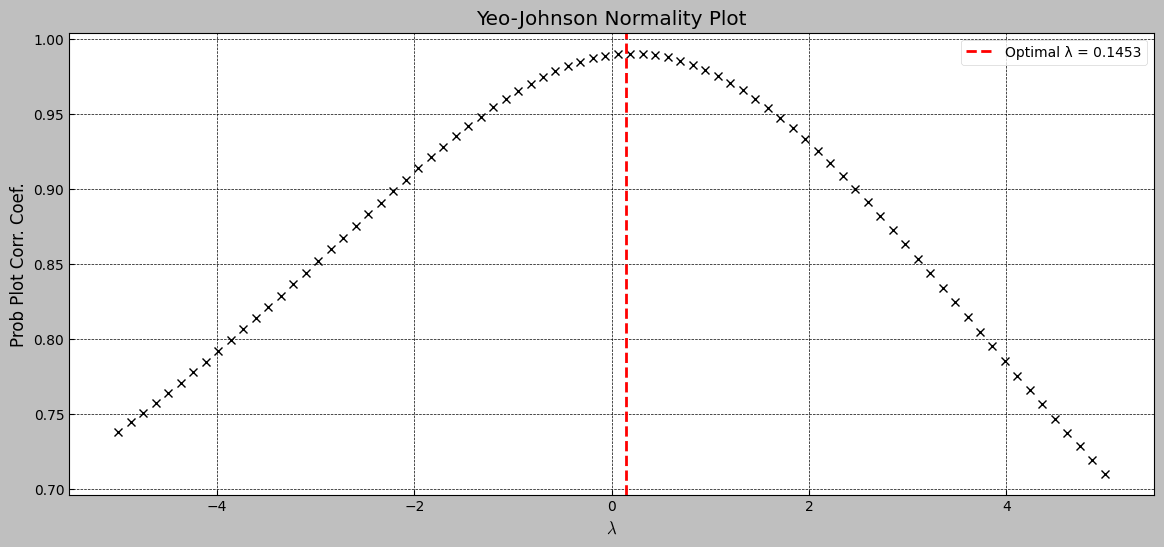

In [138]:
fig, ax = plt.subplots()
yeojohnson_normplot(airp_df['passengers'], la=-5, lb=5, plot=ax);
_, optimal_lambda = yeojohnson(airp_df['passengers']) 
ax.axvline(optimal_lambda, color='red', linestyle='--', label=f'Optimal λ = {optimal_lambda:.4f}')
plt.legend()
plt.show()

#### Using PowerTransformer from Scikit-Learn

In [139]:
from sklearn.preprocessing import PowerTransformer

In [140]:
pt = PowerTransformer(method='yeo-johnson')
y_hat = pt.fit_transform(airp_df)

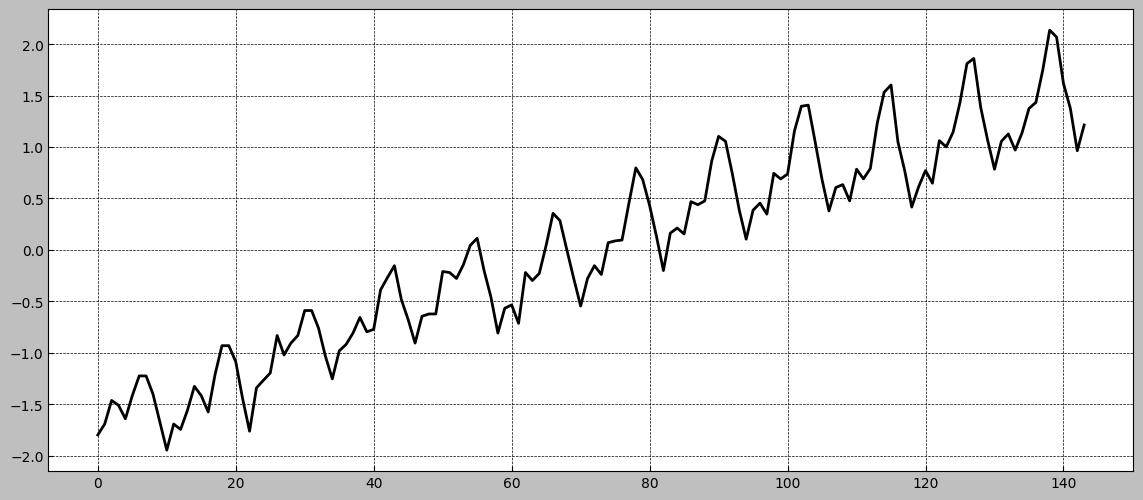

In [141]:
plt.plot(y_hat);

In [142]:
print(pt.lambdas_)

[0.14526333]


In [143]:
pt.get_feature_names_out()

array(['passengers'], dtype=object)

In [144]:
pt.get_params()

{'copy': True, 'method': 'yeo-johnson', 'standardize': True}

In [145]:
airp_restored = pt.inverse_transform(y_hat)

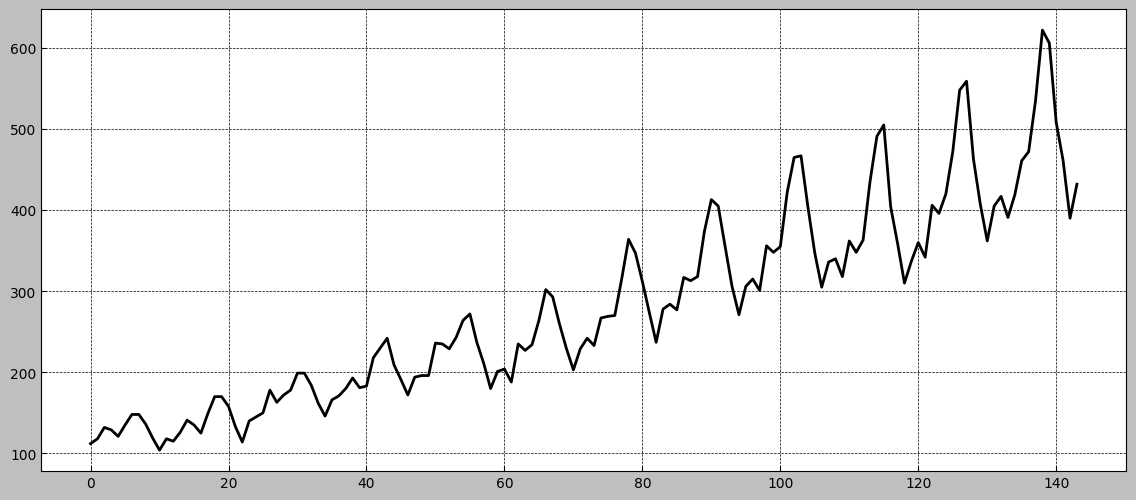

In [146]:
plt.plot(pt.inverse_transform(y_hat));


# Recipe 4. Testing for Autocorrelation

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [26]:
airp_df.head()

passengers
1949-01-31         112
1949-02-28         118
1949-03-31         132
1949-04-30         129
1949-05-31         121

In [27]:
ljung_test = acorr_ljungbox(airp_df, 
                            lags=12, 
                            return_df=True)
ljung_test['eval'] = ljung_test['lb_pvalue'] < 0.05
print(ljung_test)

        lb_stat      lb_pvalue  eval
1    132.141539   1.393231e-30  True
2    245.646160   4.556318e-54  True
3    342.674826   5.751088e-74  True
4    427.738684   2.817731e-91  True
5    504.796570  7.360195e-107  True
6    575.601854  4.264008e-121  True
7    643.038593  1.305463e-134  True
8    709.484498  6.496271e-148  True
9    779.591231  5.249370e-162  True
10   857.068639  1.100789e-177  True
11   944.390318  1.766396e-195  True
12  1036.481907  2.682212e-214  True


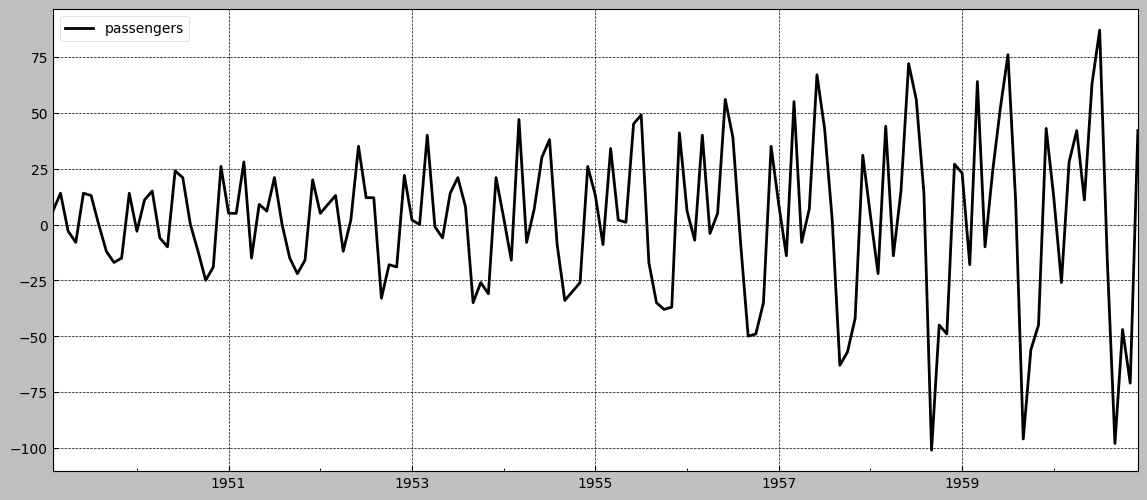

In [150]:
airp_df_diff = airp_df.diff().dropna()
airp_df_diff.plot();

In [151]:
ljung_test_diff = acorr_ljungbox(airp_df_diff, 
                                 lags=12, 
                                 return_df=True)
ljung_test_diff['eval'] = ljung_test_diff['lb_pvalue'] < 0.05
print(ljung_test_diff)

       lb_stat     lb_pvalue  eval
1    13.393249  2.525316e-04  True
2    14.927657  5.734566e-04  True
3    23.549402  3.101926e-05  True
4    37.010908  1.792006e-07  True
5    38.340604  3.223072e-07  True
6    39.271899  6.330720e-07  True
7    40.572528  9.778688e-07  True
8    53.920949  7.151547e-09  True
9    59.612069  1.592385e-09  True
10   61.328178  2.030094e-09  True
11   73.902696  2.199762e-11  True
12  182.727561  1.175064e-32  True


In [152]:
# evalauate Box-Cox transformed SARIMAX model using standardized residuals
ljung_test_resid = acorr_ljungbox(
            model_bx.filter_results.standardized_forecasts_error[0], 
            return_df=True, 
            lags=12)
ljung_test_resid['eval'] = ljung_test_resid['lb_pvalue'] < 0.05
print(ljung_test_resid)

      lb_stat  lb_pvalue   eval
1    0.376271   0.539606  False
2    0.458870   0.794983  False
3    0.734394   0.865086  False
4    2.491100   0.646230  False
5    5.058148   0.408825  False
6    6.034913   0.419290  False
7    6.662730   0.464820  False
8    6.707494   0.568495  False
9    9.827359   0.364642  False
10  10.773168   0.375461  False
11  10.814295   0.458950  False
12  10.824483   0.544017  False


## There's more

In [153]:
# evalauate Box-Cox transformed SARIMAX model using standardized residuals
ljung_test_resid = acorr_ljungbox(
            model_bx.filter_results.standardized_forecasts_error[0], 
            return_df=True, 
            boxpierce=True,
            lags=12)
print(ljung_test_resid)

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.376271   0.539606   0.368539   0.543802
2    0.458870   0.794983   0.448876   0.798965
3    0.734394   0.865086   0.714963   0.869679
4    2.491100   0.646230   2.399476   0.662722
5    5.058148   0.408825   4.843447   0.435284
6    6.034913   0.419290   5.766690   0.449827
7    6.662730   0.464820   6.355806   0.498871
8    6.707494   0.568495   6.397504   0.602798
9    9.827359   0.364642   9.282311   0.411633
10  10.773168   0.375461  10.150382   0.427400
11  10.814295   0.458950  10.187848   0.513574
12  10.824483   0.544017  10.197058   0.598678


In [154]:
model_bx.test_serial_correlation('ljungbox', lags=12)

array([[[ 0.21548538,  0.21816502,  1.06267326,  3.27081046,
          4.94169934,  6.15737005,  6.774789  ,  6.94490016,
         10.5884756 , 12.71586774, 12.71821602, 13.2886163 ],
        [ 0.64250158,  0.89665643,  0.78609167,  0.51357034,
          0.42303669,  0.40579444,  0.45269954,  0.54258907,
          0.30497416,  0.23999467,  0.31214095,  0.34841654]]])

In [155]:
model_bx.test_serial_correlation('boxpierce', lags=12)

array([[[ 0.21000693,  0.21259574,  1.02131974,  3.11717877,
          4.68894713,  5.82219948,  6.39252716,  6.54822211,
          9.85214222, 11.7631894 , 11.76527897, 12.26800464],
        [ 0.64676197,  0.89915678,  0.7960934 ,  0.53841088,
          0.45500753,  0.44339945,  0.49473448,  0.58606393,
          0.36258733,  0.301218  ,  0.38154264,  0.42440304]]])

In [1]:
import matplotlib
import pandas as pd
import hvplot
import seaborn 

print(f'''
pandas -> {pd.__version__}
matplotlob -> {matplotlib.__version__}
seaborn -> {seaborn.__version__}
hvplot -> {hvplot.__version__}
''')


pandas -> 2.3.3
matplotlob -> 3.10.6
seaborn -> 0.13.2
hvplot -> 0.12.1



In [2]:
import warnings
warnings.filterwarnings('ignore')

# Bonus Recipe 5. Plotting Time Series Data using pandas

In [32]:
import matplotlib.pyplot as plt
# reset styles
plt.rcParams["figure.figsize"] = [12, 5]  
plt.style.use('default')


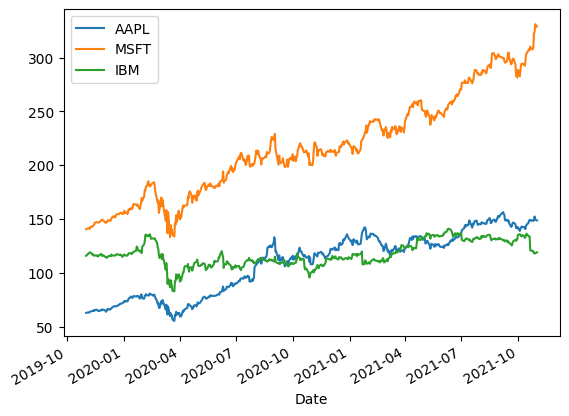

In [33]:
closing_price.plot();

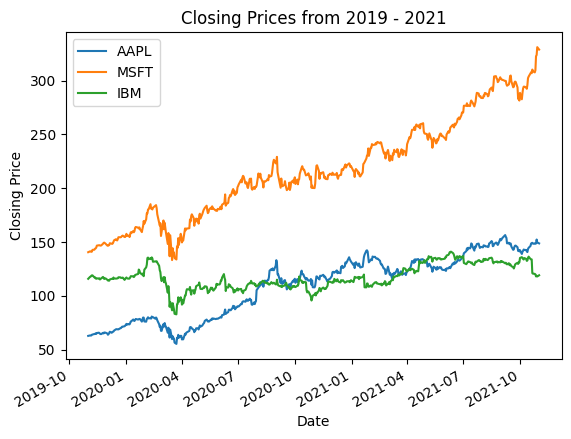

In [34]:
start_date = '2019'
end_date = '2021'
closing_price.plot(
          title=f'Closing Prices from {start_date} - {end_date}',
          ylabel= 'Closing Price');


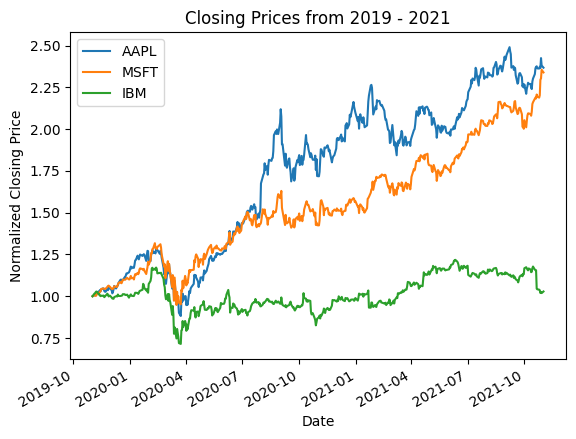

In [35]:
closing_price_n = closing_price.div(closing_price.iloc[0], axis=1)
closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Normalized Closing Price');


In [36]:
print(closing_price_n.head())

                AAPL      MSFT       IBM
Date                                    
2019-11-01  1.000000  1.000000  1.000000
2019-11-04  1.006567  1.005775  1.015790
2019-11-05  1.005121  1.005149  1.017413
2019-11-06  1.005551  1.002366  1.023980
2019-11-07  1.017156  1.003757  1.027937


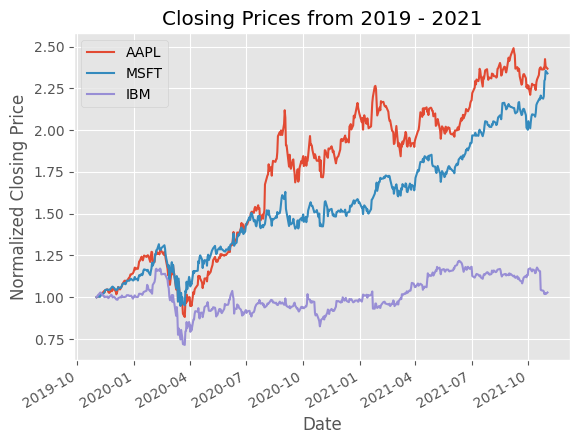

In [37]:
plt.style.use('ggplot')
closing_price_n.plot(
          title=f'Closing Prices from {start_date} - {end_date}',
          ylabel= 'Normalized Closing Price');


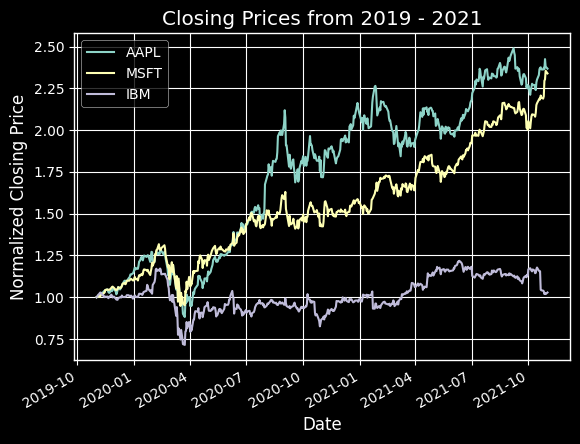

In [38]:
plt.style.use('dark_background')
closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Normalized Closing Price');

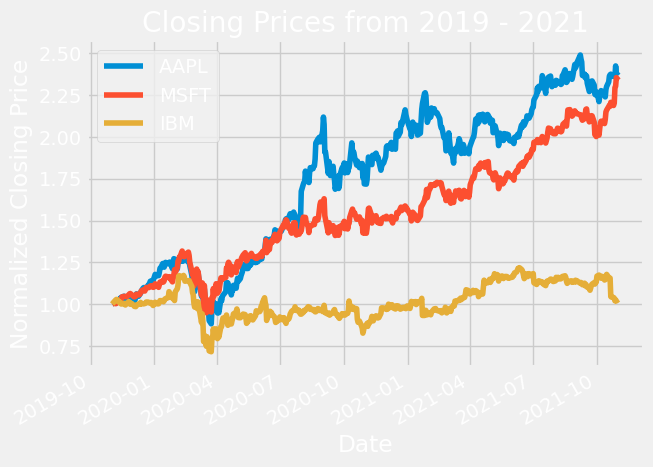

In [39]:
plt.style.use('fivethirtyeight')
closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Normalized Closing Price');

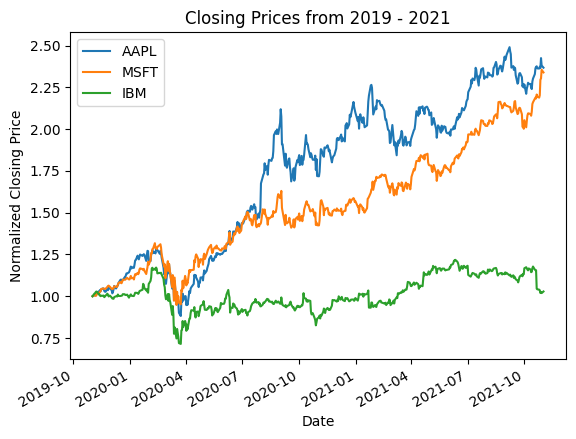

In [40]:
plt.style.use('default')
closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Normalized Closing Price');

In [41]:

# plt.rcParams.update(plt.rcParamsDefault)

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ##
# plt.rc('font', size=8)                     ## 
# plt.rc('axes', titlesize=16)               ## 
# plt.rc('axes', labelsize=14)               ##
# plt.rc('xtick', labelsize=10)              ##
# plt.rc('ytick', labelsize=10)              ##
# plt.rc('legend', fontsize=10)              ##
# plt.rc('figure', titlesize=12)             ## 
#############################################

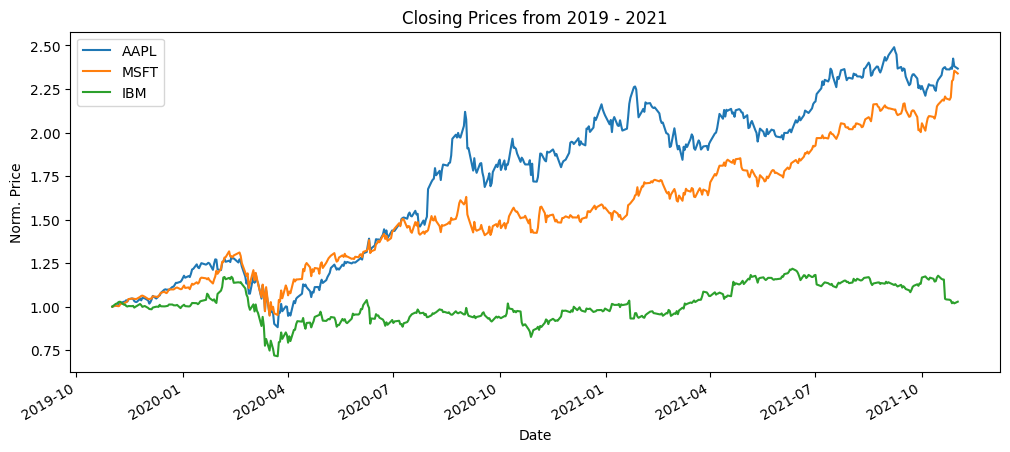

In [42]:
plot = closing_price_n.plot(
            title=f'Closing Prices from {start_date} - {end_date}',
            ylabel= 'Norm. Price')
plot.get_figure().savefig('plot_1.jpg', dpi=300)

## There is more 

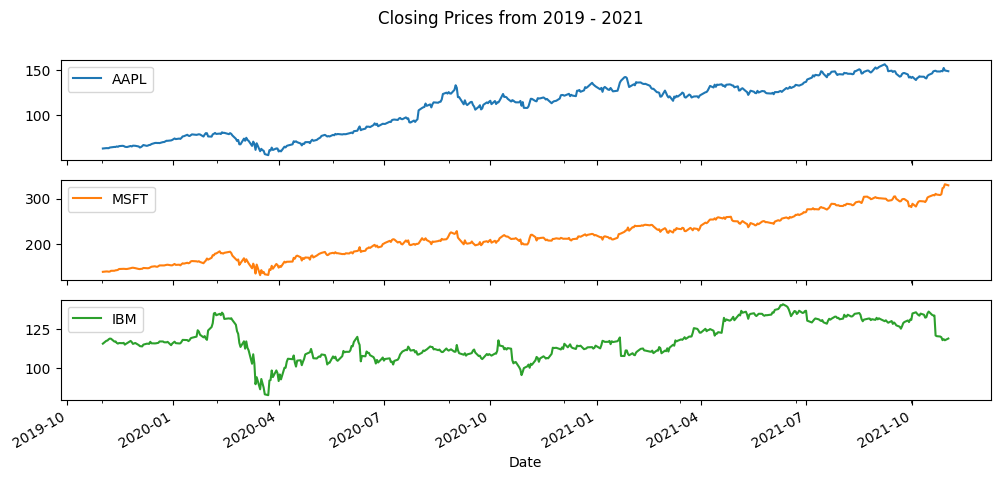

In [43]:
closing_price.plot(
           subplots=True,
           title=f'Closing Prices from {start_date} - {end_date}');


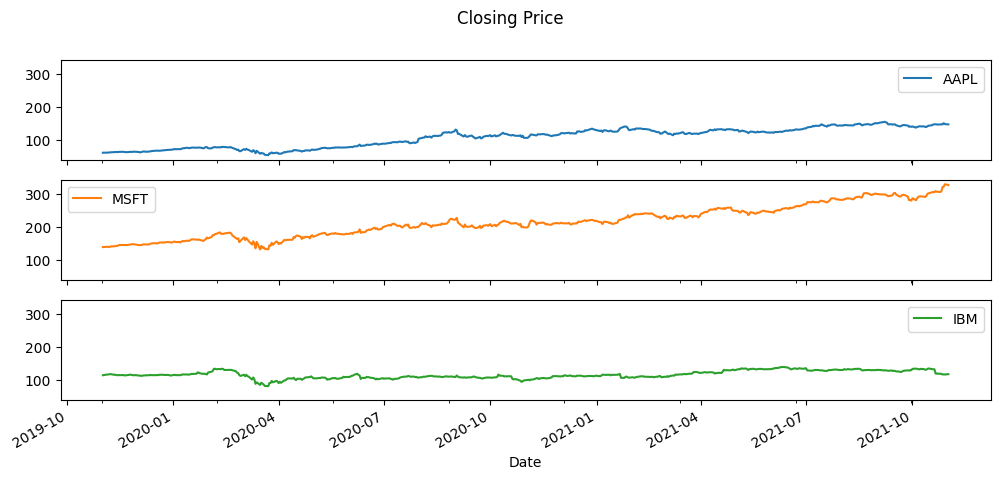

In [44]:
# with sharey = False notice the difference 
plot = closing_price.plot(
            subplots=True,
            sharey=True,
            sharex=True,
            title='Closing Price')

# Bonus Recipe 6. Plotting Time Series with Interactive Visualization using hvplot and Plotly Express

In [45]:
import pandas as pd
import hvplot.pandas 

_, closing_price, _ = load_ch8_datasets()

closing_price_n = closing_price.div(closing_price.iloc[0])

In [46]:
closing_price_n.head()

AAPL      MSFT       IBM
Date                                    
2019-11-01  1.000000  1.000000  1.000000
2019-11-04  1.006567  1.005775  1.015790
2019-11-05  1.005121  1.005149  1.017413
2019-11-06  1.005551  1.002366  1.023980
2019-11-07  1.017156  1.003757  1.027937

In [47]:
start_date = '2019'
end_date = '2021'

closing_price_n.hvplot(
    title=f'Closing Prices from {start_date} - {end_date}')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [48]:
closing_price_n.plot(
    backend='hvplot', 
    title=f'Closing Prices from {start_date} - {end_date}'
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [49]:
plot = closing_price_n.plot(backend='hvplot', 
                     title=f'Closing Prices from {start_date} - {end_date}');
plot

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [22]:
closing_price.hvplot(width=300, subplots=True)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

In [23]:
closing_price.hvplot(width=300, subplots=True).cols(2)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

### How it works

<Axes: >

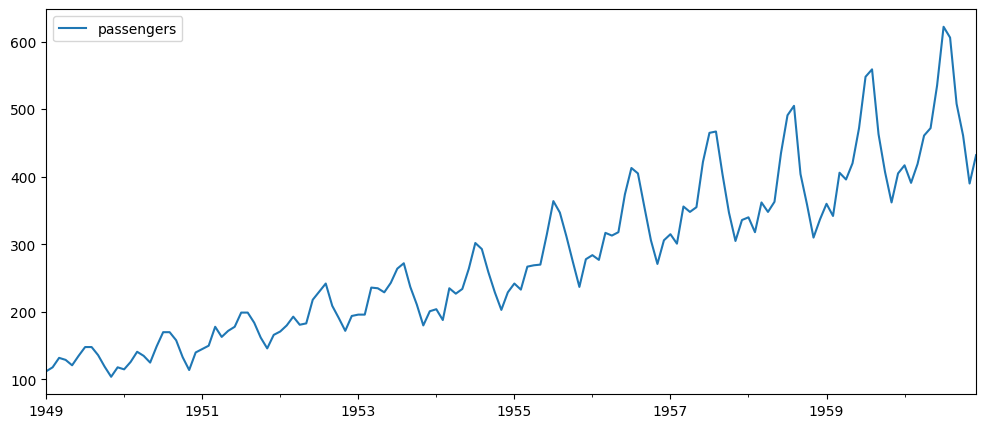

In [24]:
## you can change the backend here for all pandas plots:
## uncomment below to use Hvplot with the default Bokeh backend 

# pd.options.plotting.backend = "hvplot"

## uncomment below to use plotly you will need to install it using conda install plotly or pip install plotly
#pd.options.plotting.backend = "plotly"

## uncomment below to use Matplotlib:
pd.options.plotting.backend = "matplotlib"
airp_df.plot()

In [25]:
hvplot.extension('plotly')
airp_df.hvplot()

:Curve   [index]   (passengers)

In [26]:
hvplot.extension('bokeh')
airp_df.hvplot()

:Curve   [index]   (passengers)

In [27]:
airp_df.plot(
    backend='plotly', 
    title=f'Air Passengers'
)

In [28]:
closing_price_n.plot(
    backend='plotly', 
    title=f'Closing Prices from {start_date} - {end_date}'
)

### There is more

In [29]:
closing_price['AAPL'].hvplot.line(by=['index.year'])

:NdOverlay   [index.year]
   :Curve   [Date]   (AAPL)

In [30]:
(closing_price_n['AAPL'].hvplot(width=400) + 
 closing_price_n['MSFT'].hvplot(width=400))

:Layout
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

In [31]:
(closing_price_n['AAPL'].hvplot(width=500, height=300) * 
 closing_price_n['MSFT'].hvplot()).opts(legend_position='top_left')

:Overlay
   .Curve.AAPL :Curve   [Date]   (AAPL)
   .Curve.MSFT :Curve   [Date]   (MSFT)

In [32]:
(closing_price['AAPL'].hvplot(width=400) + closing_price['MSFT'].hvplot(width=400)) * closing_price['IBM'].hvplot()

:Layout
   .Overlay.I  :Overlay
      .Curve.AAPL :Curve   [Date]   (AAPL)
      .Curve.IBM  :Curve   [Date]   (IBM)
   .Overlay.II :Overlay
      .Curve.MSFT :Curve   [Date]   (MSFT)
      .Curve.IBM  :Curve   [Date]   (IBM)

## Seaborn subplots (optional)

In [33]:
import seaborn as sns
melted_cp = closing_price_n.copy().reset_index().melt(id_vars=['Date'], value_vars=closing_price_n.columns.tolist())
melted_cp.head()

Date variable     value
0 2019-11-01     AAPL  1.000000
1 2019-11-04     AAPL  1.006567
2 2019-11-05     AAPL  1.005121
3 2019-11-06     AAPL  1.005551
4 2019-11-07     AAPL  1.017156

In [34]:
closing_price.columns.names = ['Symbols']

<Axes: xlabel='Date'>

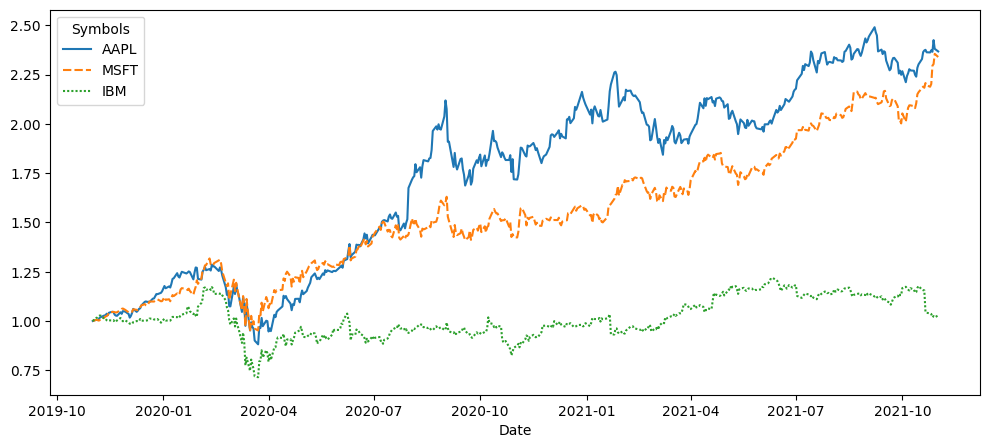

In [35]:
fig, ax = plt.subplots()
sns.lineplot(data=closing_price_n)